In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import TrafficLSTMForecaster

# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

In [2]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
# convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [3]:
preprocessor = Preprocessor(df=champs_elysees_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 43)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-07-24 05:00:00,4264,AV_Champs_Elysees,172.0,1.86667,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-12-16 09:00:00,4264,AV_Champs_Elysees,1019.0,31.12444,Saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-01-26 07:00:00,4264,AV_Champs_Elysees,480.0,5.85444,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-10-10 03:00:00,4264,AV_Champs_Elysees,486.0,6.19389,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,86.0,0.0,7.4,3.0,1025.0,100.0,10.8,0.0,NaN,False
2025-09-27 11:00:00,4264,AV_Champs_Elysees,689.0,20.29722,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,71.0,0.0,9.7,3.0,1014.7,96.0,12.8,0.0,NaN,False


In [ ]:
forecaster = TrafficLSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_processed)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)


Epoch 1/5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
Débit horaire : RMSE = 254.42, Mean = 744.92, Relative error = 34.15%
Taux d'occupation : RMSE = 8.54, Mean = 15.49, Relative error = 55.15%


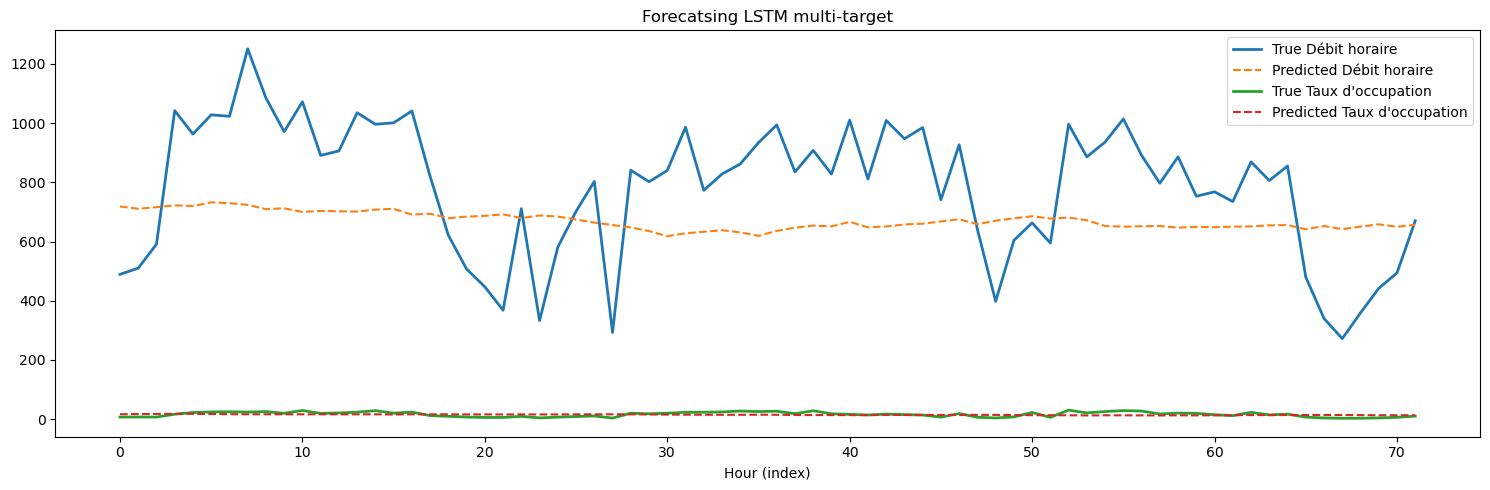

In [ ]:
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=72)